In [47]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data


In [48]:
def make_data(rng, noise, shear):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    dy, dx   = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,
    ).shear(g1=0.02, g2=-0.01,)
    
    
    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr,
    ).shear(
        g1=shear[0],
        g2=shear[1],
    ).shift(
        dx=dx,
        dy=dy,
    )
    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale=scale).array

    # psf noise
    psf_noise= .001
    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    im += rng.normal(scale=noise, size=im.shape)
    
    cen = (np.array(im.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0
    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    # noise variance map
    wt     = im*0 + 1.0/noise**2
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )
    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    return obs

In [49]:
def analyze(rng, num_tests, num_gals, noise_level, shear_true):
    data = []
    x = []
    y = []
    shear_error = []
    s2n_error = []
    for i in range(num_tests):
        print("len(data[]) =", len(data))
        dlist = []
        for j in range(num_gals):
            #These lines may be appending data[i-1] values onto data[i] 
            obs = make_data(rng=rng, noise=noise_level[i], shear=shear_true)
            resdict, obsdict = boot.go(obs)
            for stype, sres in resdict.items():
                st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                dlist.append(st)
        data.append(np.hstack(dlist))
        #data contains average of all galaxy data
        
        w = select(data=data[i], shear_type='noshear')
        w_1p = select(data=data[i], shear_type='1p')
        w_1m = select(data=data[i], shear_type='1m')
        g_1p = data[i]['g'][w_1p, 0].mean()
        g_1m = data[i]['g'][w_1m, 0].mean()
        R11 = (g_1p - g_1m)/0.02
        
        s2n = data[i]['s2n'][w].mean()
        print ("s2n =", s2n)
        s2n_err = data[i]['s2n'][w].std(axis=0)/np.sqrt(w.size)
        print("s2n_error =", s2n_err)
        s2n_error.append(s2n_err)
        
        g = data[i]['g'][w].mean(axis=0)
        shear = g / R11
        print("shear[0] =", shear[0])
        
        g_error = data[i]['g'][w].std(axis=0) / np.sqrt(w.size)
        shear_error.append(g_error[0]/R11)
        print("w.size =", w.size)
        print("g_error =", g_error)
        
        x.append(s2n)
        y.append(shear[0])
            
    return (x, y, s2n_error, shear_error)

In [50]:
rng = np.random.RandomState(1024)
# We will measure moments with a fixed gaussian weight function
weight_fwhm= 1.2
fitter     = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner     = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent
boot      = ngmix.metacal.MetacalBootstrapper(
    runner= runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
)

len(data[]) = 0
s2n = 57724.07683314287
s2n_error = 331.8460698290197
shear[0] = 0.02906071937047932
w.size = 100
g_error = [0.00024794 0.00023073]
len(data[]) = 1
s2n = 5734.469497366438
s2n_error = 30.706790028224663
shear[0] = 0.029306339070097734
w.size = 100
g_error = [0.00024679 0.00023466]
len(data[]) = 2
s2n = 577.9407416653607
s2n_error = 3.306821501824696
shear[0] = 0.028791672827094453
w.size = 100
g_error = [0.00026512 0.00024868]
len(data[]) = 3
s2n = 56.95265500284549
s2n_error = 0.3643554610597289
shear[0] = 0.028337484224065953
w.size = 100
g_error = [0.00061294 0.00066569]
x = [57724.07683314287, 5734.469497366438, 577.9407416653607, 56.95265500284549]
y = [0.02906071937047932, 0.029306339070097734, 0.028791672827094453, 0.028337484224065953]
xerr = [331.8460698290197, 30.706790028224663, 3.306821501824696, 0.3643554610597289]
yerr = [0.001493399718930705, 0.001527216975200225, 0.001635536077740136, 0.0038106872366712157]


Text(0, 0.5, '$g_{measured}$')

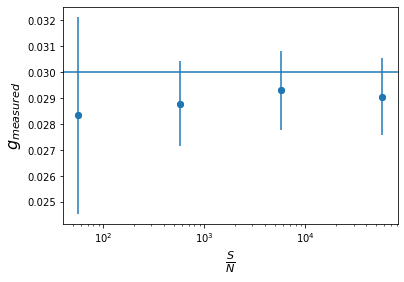

In [51]:
noise_arr = np.logspace(-6, -3, 4, base=10.0)
num_tests = len(noise_arr)
num_gals = 100
shear_true = [0.03, 0.00]
ans = analyze(rng, num_tests, num_gals, noise_arr, shear_true)
print("x =", ans[0])
print("y =", ans[1])
print("xerr =", ans[2])
print("yerr =", ans[3])

plt.errorbar(ans[0], ans[1], xerr=ans[2], yerr=ans[3], fmt='o')
plt.scatter(ans[0], ans[1])
plt.axhline(shear_true[0])
plt.xscale("log")
plt.xlabel(r'$\frac{S}{N}$', fontsize=16)
plt.ylabel(r'$g_{measured}$', fontsize=16)